In [1]:
import torch
%load_ext autoreload
%autoreload 2

In [2]:
filename = "apples"
original_image = f"data/{filename}.png"
image_fore = f"data/{filename}_fore.png"
image_back = f"data/{filename}_back.png"

In [3]:
from utils.data_utils import ImageDataset
from torch.utils.data import DataLoader

dataset = ImageDataset(original_image, image_fore, image_back)
batch_size = 1500
data_loader = DataLoader(dataset, batch_size, shuffle=True)

all_dataset = ImageDataset(original_image, None, None, train=False)
print(len(dataset))

3720


In [6]:
from models import Network, FlowNetwork
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import BCELoss
from utils.training_utils import train

plain_model = Network(5)
convex_model = Network(2, hidden_neurons=80, convex=True)
flow_model = FlowNetwork(2, 50)

optimizer = Adam(list(plain_model.parameters()) + 
                  list(convex_model.parameters())
                  + list(flow_model.parameters()),
                  lr=1e-3) #, weight_decay=5e-4)
scheduler = None
# scheduler = ReduceLROnPlateau(optimizer, "min", patience=50,
#                               verbose=True, min_lr=1e-5, threshold=1e-5)
criterion = BCELoss()
epochs = 500

plain_model, convex_model, flow_model = train(plain_model, convex_model, flow_model,
                                              data_loader, all_dataset,
                                              optimizer, criterion, scheduler, epochs, 
                                              save_log=True)

100%|██████████| 500/500 [01:52<00:00,  4.43it/s, loss=0.0091] 


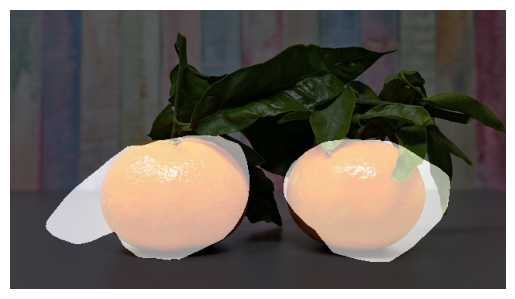

In [ ]:
from matplotlib import pyplot as plt

def show(ax, image, mask: torch.Tensor):
    mask = mask.detach().round().numpy().reshape(image.shape[:2])
    ax.imshow(image)
    ax.imshow(mask, cmap="Greys", alpha=0.6)

image = plt.imread(original_image)
# plain_predictions = plain_model(torch.tensor(all_dataset.data))
# convex_predictions = convex_model(torch.tensor(all_dataset.data[:, :2]))
connected_predictions = convex_model(flow_model(torch.tensor(all_dataset.data[:, :2])))

# fig, ax = plt.subplots(1, 3)
plt.axis("off")
# show(plt, image, plain_predictions)
# show(plt, image, convex_predictions)
show(plt, image, connected_predictions)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import pandas as pd
df = pd.read_csv(r".snapshots/log_mandarins_convex.csv", index_col="epoch")
loss_convex = df["train_loss"]
df = pd.read_csv(r".snapshots/log_mandarins_connected.csv", index_col="epoch")
loss_connected = df["train_loss"]

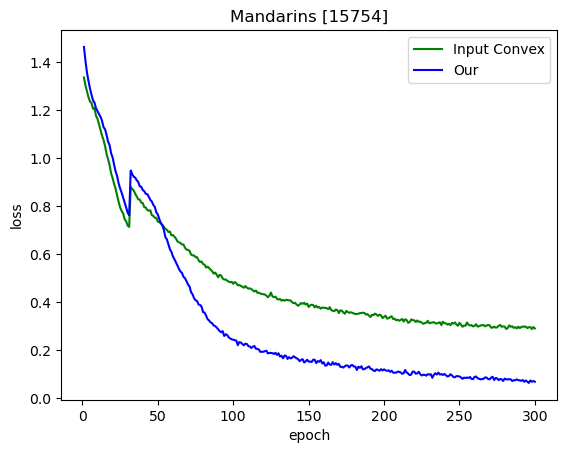

In [ ]:
end = 300
# plt.plot(loss_fc[:end], c="r")
plt.plot(loss_convex[:end], c="g")
plt.plot(loss_connected[:end], c="b")
plt.title("Mandarins [15754]")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Input Convex", "Our"])

In [5]:
from utils.data_utils import ImageDataset
from utils.log_save_utils import CheckpointManager
from models import Network, FlowNetwork
import torch

original_image = f"data/apples.png"
all_dataset = ImageDataset(original_image, None, None, train=False)

cm = CheckpointManager(".snapshots/", "plain_apples")
plain = cm.load(Network(5), None)[0]
plain_apples = plain(torch.tensor(all_dataset.data)).detach().round()

cm = CheckpointManager(".snapshots/", "convex_apples")
convex = cm.load(Network(2, hidden_neurons=80, convex=True), None)[0]
convex_apples = convex(torch.tensor(all_dataset.data[:, :2])).detach().round()

cm = CheckpointManager(".snapshots/", "convex_apples_flow")
convex = cm.load(Network(2, hidden_neurons=80, convex=True), None)[0]
cm = CheckpointManager(".snapshots/", "flow_apples")
flow = cm.load(FlowNetwork(2, 50), None)[0]
flow_apples = convex(flow(torch.tensor(all_dataset.data[:, :2]))).detach().round()

In [13]:
from torchmetrics import JaccardIndex, F1Score
iou = JaccardIndex(task='binary', num_classes=2)
print(iou(convex_apples, plain_apples), iou(flow_apples, plain_apples))
f1 = F1Score('binary', num_classes=2)
f1(convex_apples, plain_apples), f1(flow_apples, plain_apples)

tensor(0.9434) tensor(0.9464)


(tensor(0.9709), tensor(0.9724))

In [14]:
from utils.data_utils import ImageDataset
from utils.log_save_utils import CheckpointManager
from models import Network, FlowNetwork
import torch

original_image = f"data/mandarins.png"
all_dataset = ImageDataset(original_image, None, None, train=False)

cm = CheckpointManager(".snapshots/", "plain_mandarins")
plain = cm.load(Network(5), None)[0]
plain_mandarins = plain(torch.tensor(all_dataset.data)).detach().round()

cm = CheckpointManager(".snapshots/", "convex_mandarins")
convex = cm.load(Network(2, hidden_neurons=80, convex=True), None)[0]
convex_mandarins = convex(torch.tensor(all_dataset.data[:, :2])).detach().round()

cm = CheckpointManager(".snapshots/", "convex_mandarins_flow")
convex = cm.load(Network(2, hidden_neurons=80, convex=True), None)[0]
cm = CheckpointManager(".snapshots/", "flow_mandarins")
flow = cm.load(FlowNetwork(2, 50), None)[0]
flow_mandarins = convex(flow(torch.tensor(all_dataset.data[:, :2]))).detach().round()

In [16]:
from torchmetrics import JaccardIndex, F1Score
iou = JaccardIndex(task='binary', num_classes=2)
print(iou(convex_mandarins, plain_mandarins), iou(flow_mandarins, plain_mandarins))
f1 = F1Score('binary', num_classes=2)
f1(convex_mandarins, plain_mandarins), f1(flow_mandarins, plain_mandarins)

tensor(0.9183) tensor(0.9097)


(tensor(0.9574), tensor(0.9527))